In [146]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../errortools/")
import errortools
import scipy.stats
import pandas as pd

import matplotlib

SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

matplotlib.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)   # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

matplotlib.rcParams['font.family'] = 'serif'

from IPython.display import Markdown, display
def Print(string):
    display(Markdown(string))
    
np.random.seed(42)
np.set_printoptions(precision=1)

_Uncertainty/error_ = __how far__ we could be off in our prediction

Roughly two sources of uncertainty  

- Model, assumptions, features, processing, ...  

Sometimes called _systematic uncertainties_

This is not about those

- Limited training data  

Sometimes called _statistical uncertainties_

This is about those

# An illustrative example

We create a dataset according to a perfectly known sigmoid probability distribution  

In [141]:
slope = 4 
bias  = 0

-----

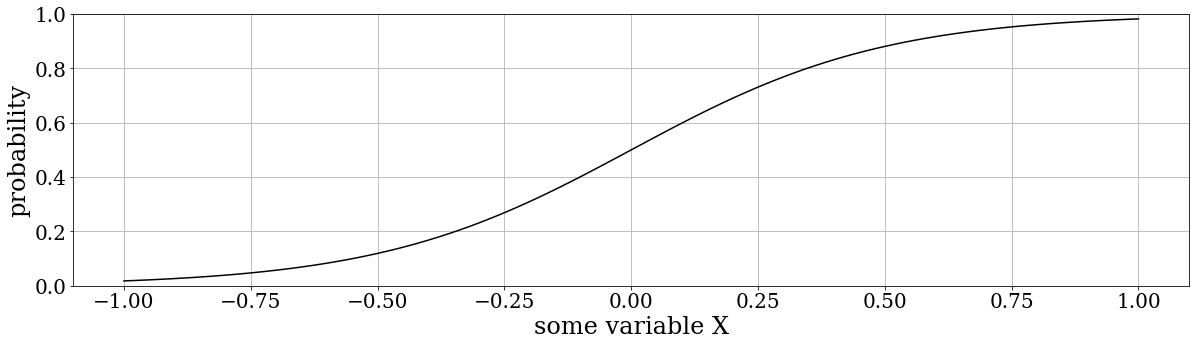

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
x = np.linspace(-1, 1, 101)
p = scipy.stats.logistic.cdf(slope * x + bias)
ax.plot(x, p, '-', color='black', alpha=1)
ax.set_xlabel("some variable X")
ax.set_ylabel("probability")
ax.grid()
ax.set_ylim((0,1));

In [143]:
n_traindata = 100
X = np.random.uniform(low=-1, high=1, size=n_traindata)
p = scipy.stats.logistic.cdf(X * slope + bias)
y = (p > np.random.uniform(size=n_traindata)).astype(int)

------

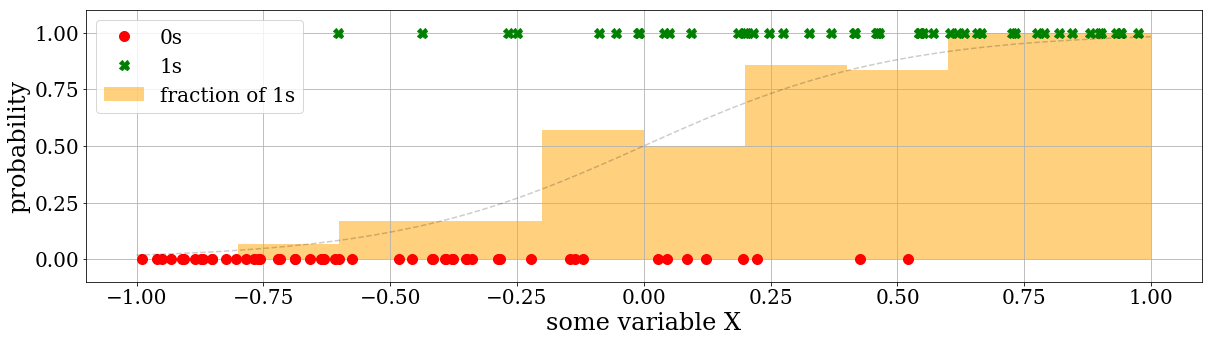

In [144]:
H, e = np.histogram(X, bins=10, range=(-1,1))
h, e = np.histogram(X[y==1], bins=10, range=(-1,1))
r = h/(H+1e-12)

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
x = np.linspace(-1, 1, 101)
p = scipy.stats.logistic.cdf(slope * x + bias)
ax.plot(X[y==0], y[y==0], 'o', color='red', markersize=10, label="0s")
ax.plot(X[y==1], y[y==1], 'X', color='green', markersize=10, label="1s")
ax.plot(x, p, '--', color='black', alpha=0.2)
ax.bar((e[:-1]+e[1:])/2., r, e[1]-e[0], color="orange", alpha=0.5, label="fraction of 1s")
ax.set_xlabel("some variable X")
ax.set_ylabel("probability")
ax.grid()
ax.legend()
ax.set_ylim((-0.1,1.1));

We fit a logistic regression to the dataset

In [147]:
model = errortools.LogisticRegression()
model.fit(X, y)
print(model.parameters)

[4.7 0.1]


---

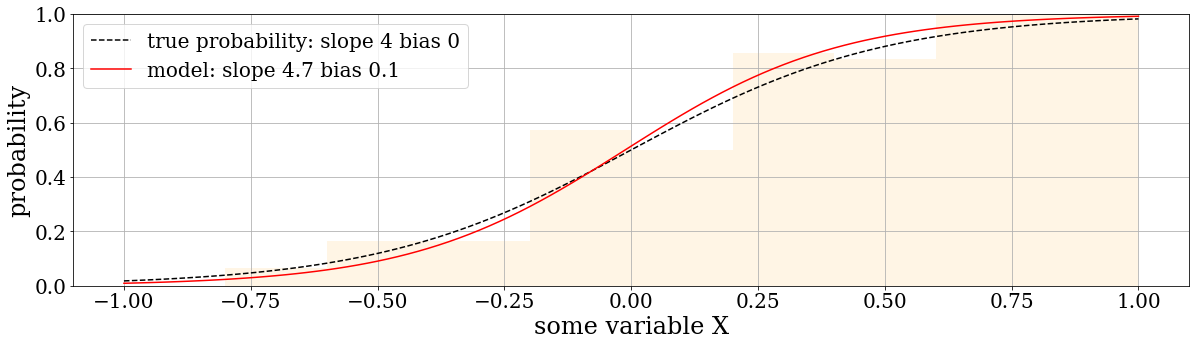

In [73]:
H, e = np.histogram(X, bins=10, range=(-1,1))
h, e = np.histogram(X[y==1], bins=10, range=(-1,1))
r = h/(H+1e-12)

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
x = np.linspace(-1, 1, 101)
p = scipy.stats.logistic.cdf(slope * x + bias)
f = model.predict(x)
ax.plot(x, p, '--', color='black', alpha=1, label="true probability: slope {:.0f} bias {:.0f}".format(slope, bias))
ax.bar((e[:-1]+e[1:])/2., r, e[1]-e[0], color="orange", alpha=0.1)
ax.plot(x, f, '-', color='red', alpha=1, label="model: slope {:.1f} bias {:.1f}".format(model.parameters[0], model.parameters[1]))
ax.set_xlabel("some variable X")
ax.set_ylabel("probability")
ax.grid()
ax.legend()
ax.set_ylim((0,1));

Our model does not get back the exact slope and bias that we put in  

The reason is the dataset  

If we had a different dataset, we would get different values

Let's illustrate this  
We repeat the example many times  

In [74]:
n_datasets = 1000
Xs = np.random.uniform(low=-1, high=1, size=(n_datasets, n_traindata))
ps = scipy.stats.logistic.cdf(Xs * slope + bias)
ys = (ps > np.random.uniform(size=Xs.shape)).astype(int)

In [76]:
models = []
for i in range(n_datasets):
    m = errortools.LogisticRegression()
    m.fit(Xs[i], ys[i])
    models.append(m)

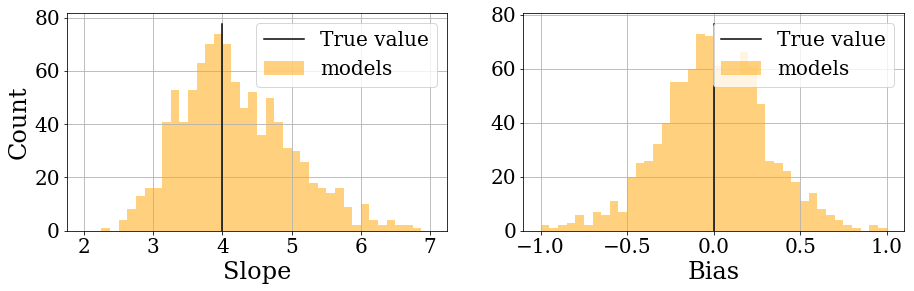

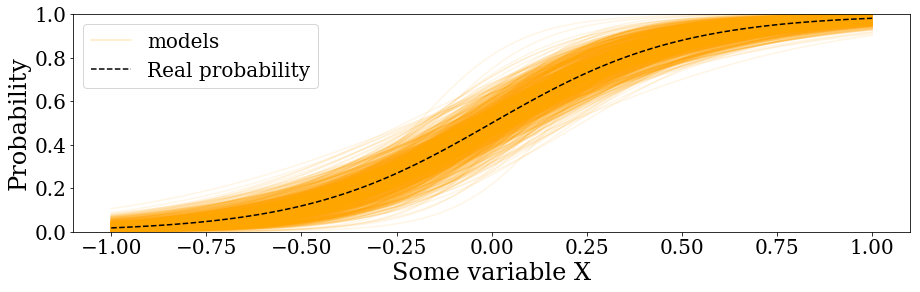

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].hist([m.parameters[0] for m in models], bins=40, range=(2,7), color='orange', alpha=0.5, label="models")
ax[0].plot((slope, slope), ax[0].get_ylim(), color='black', label="True value")
ax[0].grid()
ax[0].set_xlabel("Slope")
ax[0].set_ylabel("Count")
ax[0].legend()

ax[1].hist([m.parameters[1] for m in models], bins=40, range=(-1,1), color='orange', alpha=0.5, label="models")
ax[1].plot((bias, bias), ax[1].get_ylim(), color='black', label="True value")
ax[1].grid()
ax[1].set_xlabel("Bias")
ax[1].legend()

fig, ax = plt.subplots(1, 1, figsize=(15,4))
p = scipy.stats.logistic.cdf(slope * x + bias)
ax.plot(x, models[0].predict(x), '-', color='orange', alpha=0.25, label="models")
for m in models[1:]:
    ax.plot(x, m.predict(x), '-', color='orange', alpha=0.1)
ax.plot(x, p, '--', color='black', label="Real probability")
ax.set_ylim((0,1))
ax.set_xlabel("Some variable X")
ax.set_ylabel("Probability")
ax.legend();

### We see that

A model's parameters and prediction curves depend on the training data  

* And thereby also the AUC, confusion matrix, recall, precision, etc.  

We thus have an uncertainty on our predictions  

Can we somehow estimate these uncertainties?  


# Estimating uncertainties

Two steps

1. Estimate uncertainties on model parameters

2. Propagate uncertainties to predictions

## 1. Estimate uncertainties on model parameters

In many cases we minimize a loss function $L_{oss}(p; X, y)$  

__And implicitly maximise a likelihood__ $L(p|X,y)\sim e^{-L_{oss}(p; X, y)}$

The optimal model parameters
* minimize the loss function
* are the most likely parameters for the given dataset 

But surrounding parameter values are still likely  

---

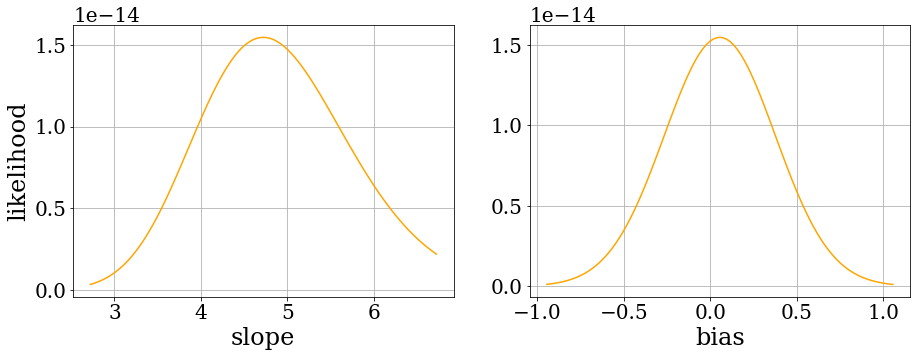

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

Z = np.concatenate((X[:, np.newaxis], np.ones((X.shape[0], 1))), axis=1)
f0 = model.negativeLogPosterior(model.parameters, Z, y, 0, 0)

p = np.tile(model.parameters, (101,1))
p[:, 0] += np.linspace(-2, 2, 101)
loss = np.exp( -np.array([model.negativeLogPosterior(q, Z, y, 0, 0) for q in p]) )

ax[0].plot(p[:, 0], loss, '-', color='orange')
ax[0].grid()
ax[0].set_xlabel("slope")
ax[0].set_ylabel("likelihood");

p = np.tile(model.parameters, (101,1))
p[:, 1] += np.linspace(-1, 1, 101)
loss = np.exp( -np.array([model.negativeLogPosterior(q, Z, y, 0, 0) for q in p]) )

ax[1].plot(p[:, 1], loss, '-', color='orange')
ax[1].grid()
ax[1].set_xlabel("bias");

We make a parabolic approximation of the loss function  
$L_{oss}(p; X, y)\approx L_{oss}(p_0) + \frac{1}{2}(p-p_0)\cdot\frac{\partial^2 L_{oss}}{\partial p^2}\cdot(p-p_0)$  

* This turns the likelihood into a multivariate Gaussian distribution  
* $L(p|X,y)\approx e^{-\frac{1}{2}(p-p_0)\cdot\frac{\partial^2 L_{oss}}{\partial p^2}\cdot(p-p_0)}$

---

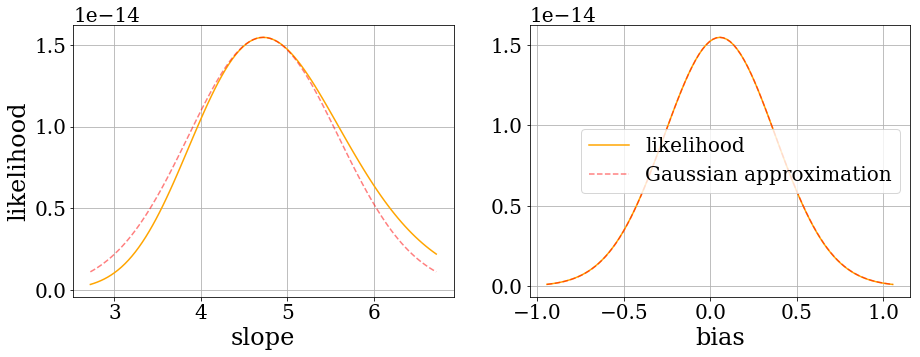

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

hessian = scipy.linalg.inv(model.cvr_mtx)
Z = np.concatenate((X[:, np.newaxis], np.ones((X.shape[0], 1))), axis=1)
f0 = model.negativeLogPosterior(model.parameters, Z, y, 0, 0)

p = np.tile(model.parameters, (101,1))
p[:, 0] += np.linspace(-model.errors[0], model.errors[0], 101)
approx = np.exp( -np.array([f0 + 0.5*np.dot(a-model.parameters, np.dot(hessian, a-model.parameters)) for a in p]) )

#ax[0].fill_between(x=p[:,0], y1=approx, color='red', hatch="x", alpha=0.05, label="86%")

p = np.tile(model.parameters, (101,1))
p[:, 0] += np.linspace(-2, 2, 101) 
loss = np.exp( -np.array([model.negativeLogPosterior(q, Z, y, 0, 0) for q in p]) )
approx = np.exp( -np.array([f0 + 0.5*np.dot(a-model.parameters, np.dot(hessian, a-model.parameters)) for a in p]) )

ax[0].plot(p[:, 0], loss, '-', color='orange', label="likelihood")
ax[0].plot(p[:, 0], approx, '--', color='red', label="Gaussian approximation", alpha=0.5)
ax[0].grid()
ax[0].set_xlabel("slope")
ax[0].set_ylabel("likelihood")

p = np.tile(model.parameters, (101,1))
p[:, 1] += np.linspace(-model.errors[1], model.errors[1], 101)
approx = np.exp( -np.array([f0 + 0.5*np.dot(a-model.parameters, np.dot(hessian, a-model.parameters)) for a in p]) )

#ax[1].fill_between(x=p[:,1], y1=approx, color='red', hatch="x", alpha=0.05, label="68%")

p = np.tile(model.parameters, (101,1))
p[:, 1] += np.linspace(-1, 1, 101)
loss = np.exp( -np.array([model.negativeLogPosterior(q, Z, y, 0, 0) for q in p]) )
approx = np.exp( -np.array([f0 + 0.5*np.dot(a-model.parameters, np.dot(hessian, a-model.parameters)) for a in p]) )

ax[1].plot(p[:, 1], loss, '-', color='orange', label="likelihood")
ax[1].plot(p[:, 1], approx, '--', color='red', label="Gaussian approximation", alpha=0.5)
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel("bias");

The approximation automatically gives us the parameter errors.
They are given by the covariance matrix  
$\hat{\Sigma}_{p} = \left[\frac{\partial^2 L_{oss}}{\partial p^2}\right]^{-1}$  

* Diagonal elements give the parameter errors
* Off-diagonal elements give the parameter correlations

------

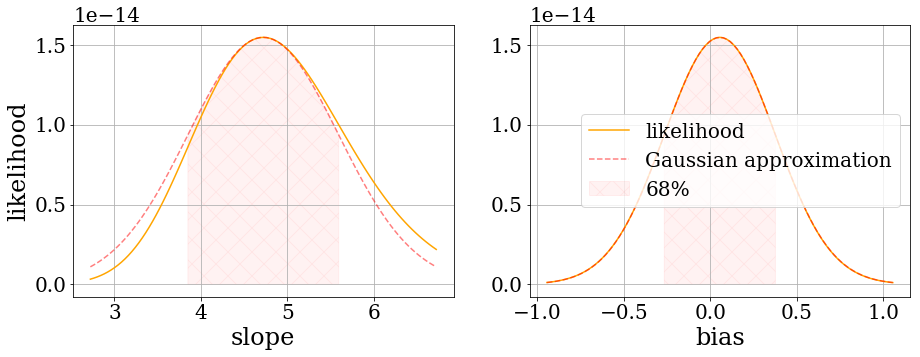

In [136]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

hessian = scipy.linalg.inv(model.cvr_mtx)
Z = np.concatenate((X[:, np.newaxis], np.ones((X.shape[0], 1))), axis=1)
f0 = model.negativeLogPosterior(model.parameters, Z, y, 0, 0)

p = np.tile(model.parameters, (101,1))
p[:, 0] += np.linspace(-model.errors[0], model.errors[0], 101)
approx = np.exp( -np.array([f0 + 0.5*np.dot(a-model.parameters, np.dot(hessian, a-model.parameters)) for a in p]) )

ax[0].fill_between(x=p[:,0], y1=approx, color='red', hatch="x", alpha=0.05, label="68%")

p = np.tile(model.parameters, (101,1))
p[:, 0] += np.linspace(-2, 2, 101) 
loss = np.exp( -np.array([model.negativeLogPosterior(q, Z, y, 0, 0) for q in p]) )
approx = np.exp( -np.array([f0 + 0.5*np.dot(a-model.parameters, np.dot(hessian, a-model.parameters)) for a in p]) )

ax[0].plot(p[:, 0], loss, '-', color='orange', label="likelihood")
ax[0].plot(p[:, 0], approx, '--', color='red', label="Gaussian approximation", alpha=0.5)
ax[0].grid()
ax[0].set_xlabel("slope")
ax[0].set_ylabel("likelihood")

p = np.tile(model.parameters, (101,1))
p[:, 1] += np.linspace(-model.errors[1], model.errors[1], 101)
approx = np.exp( -np.array([f0 + 0.5*np.dot(a-model.parameters, np.dot(hessian, a-model.parameters)) for a in p]) )

ax[1].fill_between(x=p[:,1], y1=approx, color='red', hatch="x", alpha=0.05, label="68%")

p = np.tile(model.parameters, (101,1))
p[:, 1] += np.linspace(-1, 1, 101)
loss = np.exp( -np.array([model.negativeLogPosterior(q, Z, y, 0, 0) for q in p]) )
approx = np.exp( -np.array([f0 + 0.5*np.dot(a-model.parameters, np.dot(hessian, a-model.parameters)) for a in p]) )

ax[1].plot(p[:, 1], loss, '-', color='orange', label="likelihood")
ax[1].plot(p[:, 1], approx, '--', color='red', label="Gaussian approximation", alpha=0.5)
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel("bias");

The _Minuit_ minimisation package automatically calculates the parameter covariance matrix  
* _Minuit_ is a robust, age tested minimisation package, used extensively in particle physics
* It is available in Python through the `iminuit` package
* We use `iminuit` where possible for its robustness and its covariance matrix calculation

## 2. Propagate uncertainties to predictions

A prediction is a function of input features $X$ and model parameters $p$  
 * $f(X|p) = \frac{1}{1+e^{-X\cdot p}}$  
 
The most likely model parameters $p_0$ determine the prediction  

And the uncertainties in the parameters propagate to an uncertainty in the prediction 
* Multiple ways to propagate uncertainties

**Linear error propagation**  
   * Linear approximation of the prediction function
       * $f(X|p)\approx f(X|p_0)+\frac{\partial f}{\partial p}(X|p_0)\cdot(p-p_0)$
   * Makes the prediction uncertainty a simple equation
       * $\Delta f \approx  \sqrt{\frac{\partial f}{\partial p}(X|p_0) \cdot \hat{\Sigma}_p \cdot \frac{\partial f}{\partial p}(X|p_0)}$  
       
Fast calculation, but may be inexact    

**Sample the Gaussian likelihood**  
* Take random parameters $p$ from $L(p|X,y)\approx e^{-\frac{1}{2}(p-p_0)\cdot\hat{\Sigma}_{p}^{-1}\cdot(p-p_0)}$ 
* Calculate $E_p\left[ \left(f(X|p)-f(X|p_0)\right)^2 \right]$  

Slower, but more exact with more samples

------

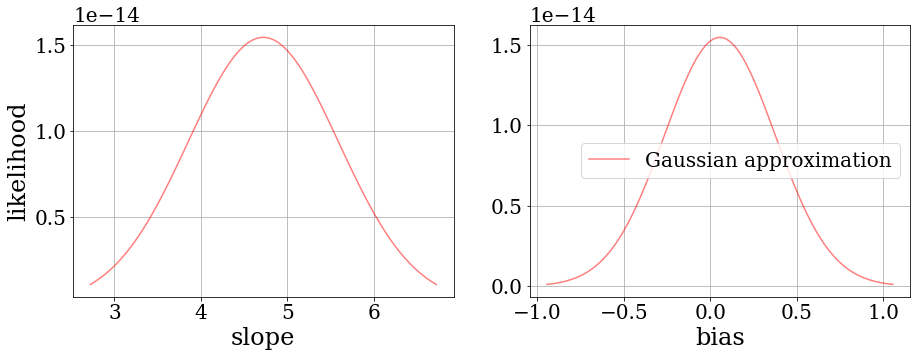

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

hessian = scipy.linalg.inv(model.cvr_mtx)
Z = np.concatenate((X[:, np.newaxis], np.ones((X.shape[0], 1))), axis=1)
f0 = model.negativeLogPosterior(model.parameters, Z, y, 0, 0)

p = np.tile(model.parameters, (101,1))
p[:, 0] += np.linspace(-model.errors[0], model.errors[0], 101)
approx = np.exp( -np.array([f0 + 0.5*np.dot(a-model.parameters, np.dot(hessian, a-model.parameters)) for a in p]) )

#ax[0].fill_between(x=p[:,0], y1=approx, color='red', hatch="x", alpha=0.05, label="86%")

p = np.tile(model.parameters, (101,1))
p[:, 0] += np.linspace(-2, 2, 101) 
loss = np.exp( -np.array([model.negativeLogPosterior(q, Z, y, 0, 0) for q in p]) )
approx = np.exp( -np.array([f0 + 0.5*np.dot(a-model.parameters, np.dot(hessian, a-model.parameters)) for a in p]) )

#ax[0].plot(p[:, 0], loss, '-', color='orange', label="likelihood")
ax[0].plot(p[:, 0], approx, '-', color='red', label="Gaussian approximation", alpha=0.5)
ax[0].grid()
ax[0].set_xlabel("slope")
ax[0].set_ylabel("likelihood")

p = np.tile(model.parameters, (101,1))
p[:, 1] += np.linspace(-model.errors[1], model.errors[1], 101)
approx = np.exp( -np.array([f0 + 0.5*np.dot(a-model.parameters, np.dot(hessian, a-model.parameters)) for a in p]) )

#ax[1].fill_between(x=p[:,1], y1=approx, color='red', hatch="x", alpha=0.05, label="68%")

p = np.tile(model.parameters, (101,1))
p[:, 1] += np.linspace(-1, 1, 101)
loss = np.exp( -np.array([model.negativeLogPosterior(q, Z, y, 0, 0) for q in p]) )
approx = np.exp( -np.array([f0 + 0.5*np.dot(a-model.parameters, np.dot(hessian, a-model.parameters)) for a in p]) )

#ax[1].plot(p[:, 1], loss, '-', color='orange', label="likelihood")
ax[1].plot(p[:, 1], approx, '-', color='red', label="Gaussian approximation", alpha=0.5)
ax[1].grid()
ax[1].legend()
ax[1].set_xlabel("bias");

# Uncertainties in action

Surviving the Titanic

Get information on Titanic passengers

In [ ]:
df = pd.read_csv("http://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv")